# Bayesian logistic regression:

In [1]:
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from coinem.model import AbstractModel

/Users/danieldodd/miniconda3/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
from sklearn.datasets import fetch_covtype
from coinem.dataset import Dataset

# Load in the Covertype dataset
data = fetch_covtype()

# Get the features and target variable
X =  jnp.array(data.data)
y =  jnp.array(data.target == 2).astype(float)
D = Dataset(X, y)

In [4]:
import tensorflow_probability.substrates.jax.distributions as tfd

@dataclass
class LogisticRegression(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D 1"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        alpha = jnp.exp(latent[0])
        beta = latent[1:]


        # likelihood
        z = jnp.matmul(data.X, beta)
        log_lik = tfd.Bernoulli(logits=z).log_prob(data.y.squeeze()).sum()
        

        # Compute linear predictor.
        z = jnp.matmul(data.X, beta)

        # Prior
        log_prior = tfd.Normal(loc=0.0, scale=1.0/jnp.sqrt(alpha)).log_prob(beta).sum().squeeze()
        log_prior_alpha = tfd.Gamma(concentration=jnp.exp(theta[0]), rate=jnp.exp(theta[1])).log_prob(alpha).sum().squeeze()


        # Compute log-probability.
        return log_lik + log_prior + log_prior_alpha

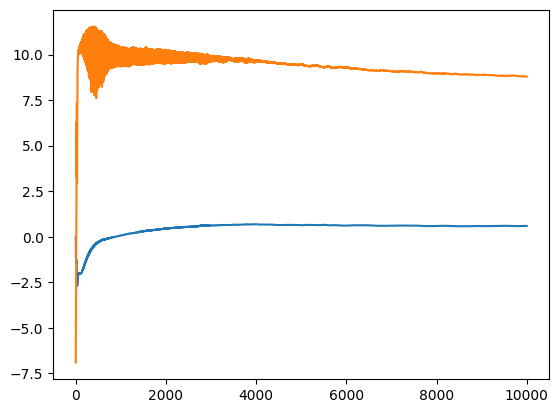

In [10]:
likelihood = LogisticRegression()


# Set approximation parameters:
K = 10000  # Number of steps.
N = 20  # Number of particles.

# Initialize parameter estimates and particle cloud, all at zero:
import jax.random as jr
key = jr.PRNGKey(123)

th0 = jnp.log(jnp.array([1.0, 1e-3]))  # Parameter estimate.
X0 = jr.normal(key, (N, 1 + D.X.shape[-1]))  # Particle cloud.


from coinem.zoo import coin_svgd

X_coin, th_coin = coin_svgd(likelihood, D, X0, th0, K, batch_size=500)

plt.plot(th_coin[:, 0])
plt.plot(th_coin[:, 1])